# England 2020-2021 - Community Life Survey

In [1]:
import pandas as pd
import numpy as np

# Note: requires installation of odfpy and feather-format

## Load Community Life Survey

- Community Life Survey is household self completion study conducted every year by DCSM 
- Asks 1 direct and 3 indirect questions on loneliness 
- The raw data is not published, only qual summaries
- However there is an ad-hoc release - Community Life Survey: Strength of community variables by Output Area Classification, 2017/18 to 2020/21 
- https://www.gov.uk/government/statistical-data-sets/dcms-community-life-survey-ad-hoc-statistical-releases
- Data only provided for the one direct question of loneliness
- This notebook isolates 2020/21 and maps the results to LSOA 21
- Numbers represent responses of "Often/always & some of the time" to "How often do you feel lonely?"

In [2]:
# Read loneliness sheet of community life survey for 2020/21
df = pd.read_excel("../../extdata/cls.ods",  engine="odf", sheet_name = "A6", skiprows = 26, nrows =1)

In [3]:
df.drop(columns=df.columns[:3], axis=1, inplace=True)

In [4]:
df = (df.T).reset_index()
df.rename(columns = {"index": "oac_11", 0: "perc" }, inplace = True)
df.drop(index=df.index[-1],axis=0,inplace=True)

In [5]:
df['oac_11'] = df.oac_11.str[-2:]

In [6]:
# No data for one of the OACs ("where total number of responses is less than 30. this data has been supressed"); 
# replace with np.nan
df.loc[19, 'perc'] = np.nan

 Length of df: 26


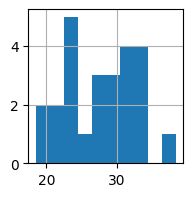

In [7]:
print(f" Length of df: {len(df)}")
df.perc.hist(figsize = (2,2));

## Join OAC to OA

- Data is analysed by the 26 groups of the 2011 Area Classification for Output Areas which groups areas with similar characteristics
- Lookup for OAC '11 TO OA'11 is here https://www.ons.gov.uk/methodology/geography/geographicalproducts/areaclassifications/2011areaclassifications/datasets

**NB: File needs to be downloaded locally as it is >100mb**

In [8]:
# Read csv to join OAC to OA
oa = pd.read_csv("../../extdata/oac_lookup.csv")
oa = oa[["Output Area Code", "Group Code"]]
oa.rename(columns = {"Group Code": "oac_11", "Output Area Code":"oa11_code"}, inplace = True )

In [9]:
# Join to loneliness perc
df_oa = oa.merge(df, on = 'oac_11', how = 'left')

In [10]:
# Check
print(oa.oa11_code.nunique() == df_oa.oa11_code.nunique())
print(f" Length of df_oa: {len(df_oa)}")

True
 Length of df_oa: 232296


## Join OA11 to LSOA 11

In [11]:
# Read file from geographr to join OA 11 to LSOA 11; saved as a feather file
lookup_11 = pd.read_feather("../../extdata/lookup_11.feather")
lookup_11 = lookup_11[['lsoa11_code','oa11_code']]

**NB: File needs to be downloaded locally as it is >100mb**

In [12]:
# Filter for England  and unique combos of oa11_code and lsoa11_code
lookup_11 = lookup_11[lookup_11['lsoa11_code'].str.startswith('E')]
lookup_11 = lookup_11.drop_duplicates(subset = ['oa11_code','lsoa11_code'])

In [13]:
df_lsoa11 = lookup_11.merge(df_oa, on = 'oa11_code', how = 'left')

In [14]:
# check
len(df_lsoa11) == lookup_11.oa11_code.nunique()

True

In [15]:
# Check that the only NAs for perc is from the same OAC that didn't have data
df_lsoa11[df_lsoa11['perc'].isna()]['oac_11'].value_counts()

oac_11
7b    556
Name: count, dtype: int64

In [16]:
# Get average of each LSOA
df_lsoa11.perc = df_lsoa11.perc.astype(float)
df_lsoa11 = df_lsoa11.groupby(['lsoa11_code'], as_index = False)['perc'].mean()

In [17]:
# Check there are 32,844 LSOAs in England in 201
print(df_lsoa11.lsoa11_code.nunique() == lookup_11.lsoa11_code.nunique() == 32844)
print(f" Length of df_oa: {len(df_lsoa11)}")

True
 Length of df_oa: 32844


## Join LSOA 11 to LSOA 21

Although LSOA11 : LSOA21 is not a 1:1 relationship, each observation in the geographr lookup table is at LSOA11 level so a left join will capture all the changes.

In [18]:
# Read file from geographr to join lsoa 11 code to lsoa 21 code; saved as a feather file
lookup_21 = pd.read_feather("../../extdata/lookup_21.feather")

**NB: File needs to be downloaded locally as it is >100mb**

In [19]:
# Filter for England and take unique combinations for lsoa11 - lsoa21
lookup_21 = lookup_21[lookup_21['lsoa21_code'].str.startswith('E')]
lookup_21 = lookup_21.drop_duplicates(subset = ['lsoa11_code', 'lsoa21_code'])

In [20]:
lookup_21 = lookup_21[["lsoa11_code", "lsoa21_code"]]
loneliness = pd.merge(df_lsoa11, lookup_21, on = "lsoa11_code", how = "left")

In [21]:
# check that len is same as lookup_21 rather than df_lsoa11
len(lookup_21) == len(loneliness)

True

In [22]:
loneliness = loneliness[["lsoa21_code", "perc"]]

In [23]:
loneliness = loneliness.groupby("lsoa21_code", as_index = False).mean()

In [24]:
# Check there are 33,755 LSOAs and no nulls
loneliness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33755 entries, 0 to 33754
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lsoa21_code  33755 non-null  object 
 1   perc         33755 non-null  float64
dtypes: float64(1), object(1)
memory usage: 527.5+ KB


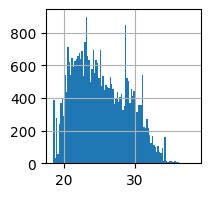

In [25]:
loneliness.perc.hist(bins = 100, figsize = (2,2));

In [26]:
loneliness.sample(5)

,lsoa21_code,perc
4888,E01005167,28.670639
18542,E01019547,26.014174
19279,E01020311,20.752053
30126,E01031731,30.526910
23420,E01024676,29.134239


In [27]:
loneliness.to_csv("../../extdata/england_cls_loneliness_2020.csv", index = False )